In [5]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome
from copy import deepcopy

import ipywidgets as widgets
import pandas as pd
import csv
import matplotlib.pyplot as plt
from IPython.display import display

In [19]:
test_name = "new_3d_3"
dir_path = f"../checkpoints/{test_name}"
csvs = os.listdir(dir_path)
csvs = [f for f in csvs if "csv" in f]

csvs.sort()
csvs_name=widgets.Dropdown(
    options=csvs,
    description='Env',
    disabled=False,
)
display(csvs_name)

Dropdown(description='Env', options=('env_0_results.csv', 'env_15_results.csv', 'env_28_results.csv', 'env_29_…

In [20]:
tests_3d = ["new_3d_1","new_3d_2","new_3d_3"]
tests_cppn = ["new_cppn_1","new_cppn_2","new_cppn_3"]

fitnesses = []
for test_name in tests_3d:
# for test_name in tests_cppn:
    dir_path = f"../checkpoints/{test_name}"
    csvs = os.listdir(dir_path)
    csvs = [f for f in csvs if "csv" in f]
    csvs.sort()
    valid_envs = {}
    for csv in csvs:
        file_name = dir_path + "/" + csv
        temp_df = pd.read_csv(file_name, sep=';')
        if len(temp_df) > 30:
            valid_envs[csv] = temp_df
    test_avg_fits = []
    for g in range(1, 201):
        f = 0
        qtd = 0
        for name in valid_envs:
            df = valid_envs[name]            
            fit = df.loc[df['global_gen'] == g]
            if len(fit["best_fit"] > 0):
                f += fit.iloc[0]["best_fit"]
                qtd += 1
        test_avg_fits.append(f/qtd)
    fitnesses.append(test_avg_fits)


In [21]:
# print(fitnesses[0])
max_arr = []
min_arr = []
avg_arr = []

for fits in fitnesses:
    for i in range(5):
        if len(fits) < 206:
            fits.append(fits[-1])

for g in range(1, 206):
    fs = [f[g] for f in fitnesses]
    avg_arr.append(np.average(fs))
    max_arr.append(max(fs))
    min_arr.append(min(fs))

# for res in zip(fitnesses)

plt.figure(figsize=(20,6))
gens_arr = [x for x in range(1, 206)]
plt.plot(gens_arr, avg_arr, lw =2, label="Avg fitness across environments", color="orange")
plt.fill_between(gens_arr, min_arr,max_arr, alpha = 0.15, color="orange")

flag = True
for i in range(45, 201, 45):
    if flag:
        plt.axvline(x = i, color = 'r', label = 'Creation of new environments', lw = 1, alpha = 1)
        flag = False
    plt.axvline(x = i, color = 'r', lw = 1, alpha = 0.5)

flag = True
for i in range(100, 201, 100):
    if flag:
        plt.axvline(x = i, color = 'g', label = 'Direct Transfer', lw = 1, alpha = 1)
        flag = False
    plt.axvline(x = i, color = 'g', lw = 1, alpha = 1)

flag = True    
for i in range(10, 201, 10):
    if flag:
        plt.axvline(x = i, color = 'b', label = 'Proposal Transfer', lw = 0.5, alpha = 0.4)
        flag = False
    plt.axvline(x = i, color = 'b', lw = 0.5, alpha = 0.4)


plt.xlabel("Generations", fontsize=16)
plt.ylabel("Fitness", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.title('POET run with 3D substrate', fontsize = 18)
plt.show()

IndexError: list index out of range

In [37]:
test_name = "new_3d_3"
dir_path = f"../checkpoints/{test_name}"
csvs = os.listdir(dir_path)
csvs = [f for f in csvs if "csv" in f]

csvs.sort()
csvs_name=widgets.Dropdown(
    options=csvs,
    description='Env',
    disabled=False,
)
valid_envs = {}
for csv in csvs:
    file_name = dir_path + "/" + csv
    print(file_name)
    temp_df = pd.read_csv(file_name, sep=';')
    if len(temp_df) > 30:
        valid_envs[csv] = temp_df

../checkpoints/new_3d_3/env_0_results.csv
../checkpoints/new_3d_3/env_15_results.csv
../checkpoints/new_3d_3/env_28_results.csv
../checkpoints/new_3d_3/env_29_results.csv
../checkpoints/new_3d_3/env_36_results.csv
../checkpoints/new_3d_3/env_44_results.csv
../checkpoints/new_3d_3/env_47_results.csv
../checkpoints/new_3d_3/env_4_results.csv
../checkpoints/new_3d_3/env_51_results.csv
../checkpoints/new_3d_3/env_65_results.csv
../checkpoints/new_3d_3/env_66_results.csv
../checkpoints/new_3d_3/env_71_results.csv
../checkpoints/new_3d_3/env_9_results.csv


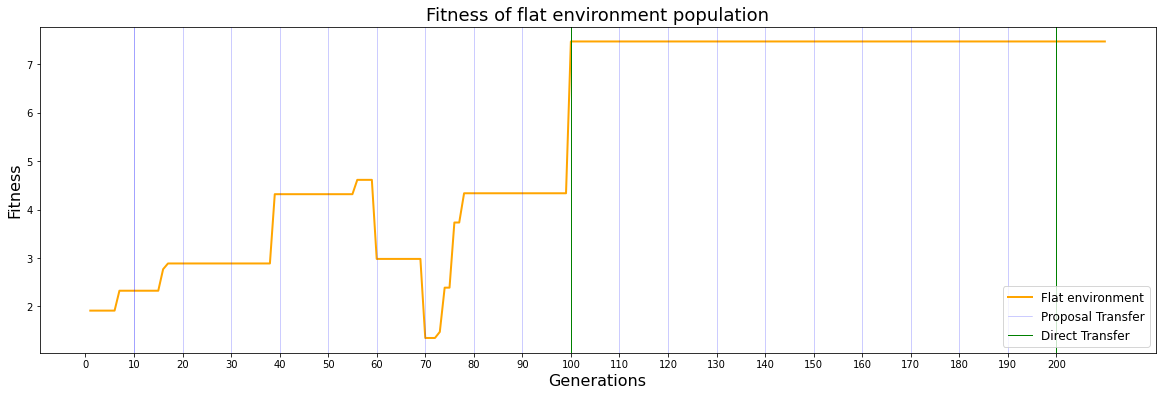

0


In [46]:
largest_size = 0

plt.figure(figsize=(20,6))
cont = 0

for name in valid_envs:
    if cont == 0:
        gens = [x for x in valid_envs[name]["global_gen"]]
        fits = [x for x in valid_envs[name]["best_fit"]]
        for i in range(10):
            gens.append(gens[-1] + 1)
            fits.append(fits[-1])
        # plt.plot(gens, fits, lw =2, label="Environment " + str(cont), color="orange")
        plt.plot(gens, fits, lw =2, label="Flat environment", color="orange")

        flag = True    
        for i in range(10, 201, 10):
            if flag:
                plt.axvline(x = i, color = 'b', label = 'Proposal Transfer', lw = 0.5, alpha = 0.4)
                flag = False
            plt.axvline(x = i, color = 'b', lw = 0.5, alpha = 0.4)

        flag = True
        for i in range(100, 201, 100):
            if flag:
                plt.axvline(x = i, color = 'g', label = 'Direct Transfer', lw = 1, alpha = 1)
                flag = False
            plt.axvline(x = i, color = 'g', lw = 1, alpha = 1)

    cont += 1

plt.xlabel("Generations", fontsize=16)
plt.xticks(np.arange(0, 202, 10))
plt.ylabel("Fitness", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.title('Fitness of flat environment population', fontsize = 18)
plt.show()
print(largest_size)